In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import StepLR, SequentialLR, LambdaLR, OneCycleLR
import os
import matplotlib.pyplot as plt
import numpy as np
import copy
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [2]:
lambda_data = '/mnt/d/Users/Admin/Projects/Machine_Learning/data'
delta_data = '/workspace/alvin/Machine_Learning_Studying/data'
data_lst = [lambda_data, delta_data]
data_pth = data_lst[0]

In [3]:
data_transforms = {
    "train" : transforms.Compose([
        transforms.Resize(size = (224, 224)), # resize to 224 by 224 for resnet
        # transforms.CenterCrop(size = (224, 224)),
        transforms.Grayscale(num_output_channels = 3), # this converts grayscale to rgb channels
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
    "test" : transforms.Compose([
        transforms.Resize(size = (224, 224)), # resize to 224 by 224 for resnet
        # transforms.CenterCrop(size = (224, 224)),
        transforms.Grayscale(num_output_channels = 3), # this converts grayscale to rgb channels
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
}

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [5]:
training_data = datasets.FashionMNIST(
    root = data_pth,
    train = True,
    download = True,
    transform = data_transforms["train"]
)

train_ds, val_ds = random_split(training_data, [50_000, 10_000])

ds_dict = {"train" : train_ds, "val" : val_ds}
dataset_sizes = {"train" : len(train_ds), "val" : len(val_ds)}

In [6]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /mnt/d/Users/Admin/Projects/Machine_Learning/data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=3)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
dataloaders = {x : DataLoader(ds_dict[x], batch_size = 2**9, num_workers = 4, shuffle = True) for x in ds_dict.keys()}

In [9]:
# load pre-trained model
model = models.resnet18(weights = "DEFAULT")
# Replace final layer for the number of classes
model.fc = nn.Linear(model.fc.in_features, len(labels_map))

# Freeze all layers except final layer
# final layer is responsible for classification
for name, param in model.named_parameters():
    if "fc" in name:
        # unfreeze the fc layers
        # this means we are only training the fc layers
        param.requires_grad = True 
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() # most common used nn for classification problems
# optimizer = optim.SGD(model.parameters(), lr = 0.01)
# scheduler = StepLR(optimizer, step_size = 10, gamma = 0.1) # this multiplies lr every 10 epoch by 0.1

optimizer = optim.SGD(model.parameters(), lr = 0.1)

# def warmup_lambda(epoch):
#     if epoch < 20:
#         # scale from 0.5 (0.1/0.2) up to 1.0
#         return 0.5 + (epoch / 20) * 0.5
#     return 1.0

# scheduler1 = LambdaLR(optimizer, lr_lambda = warmup_lambda)
# scheduler2 = StepLR(optimizer, step_size = 4, gamma = 0.5)
# scheduler = SequentialLR(optimizer, schedulers = [scheduler1, scheduler2], milestones = [20])

scheduler = OneCycleLR(optimizer, max_lr = 0.0125, epochs = 50, steps_per_epoch = len(dataloaders["train"]))

# move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# No Early Stoppage 

In [9]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

# Training loops
num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0 # correct predictions

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # clear the gradient from previous iteration

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels) # check if output and labels match

                if phase == "train":
                    loss.backward()
                    optimizer.step()
                    scheduler.step() # scheduler here if OneCycleLR

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
        history[f"{phase}_loss"].append(epoch_loss)
        history[f"{phase}_acc"].append(epoch_acc.item())

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # scheduler.step()
    print(f"Epoch {epoch} LR: {scheduler.get_last_lr()[0]:.10f}")

print("Training complete!")

Epoch 0
train Loss: 1.5758 Acc: 0.5318
val Loss: 0.9736 Acc: 0.7594
Epoch 0 LR: 0.0006312923
Epoch 1
train Loss: 0.7969 Acc: 0.7815
val Loss: 0.6826 Acc: 0.7933
Epoch 1 LR: 0.0010194234
Epoch 2
train Loss: 0.6237 Acc: 0.8072
val Loss: 0.5798 Acc: 0.8118
Epoch 2 LR: 0.0016474069
Epoch 3
train Loss: 0.5453 Acc: 0.8228
val Loss: 0.5217 Acc: 0.8242
Epoch 3 LR: 0.0024877599
Epoch 4
train Loss: 0.4994 Acc: 0.8327
val Loss: 0.4822 Acc: 0.8352
Epoch 4 LR: 0.0035037049
Epoch 5
train Loss: 0.4683 Acc: 0.8401
val Loss: 0.4565 Acc: 0.8419
Epoch 5 LR: 0.0046507801
Epoch 6
train Loss: 0.4463 Acc: 0.8475
val Loss: 0.4424 Acc: 0.8446
Epoch 6 LR: 0.0058787848
Epoch 7
train Loss: 0.4306 Acc: 0.8505
val Loss: 0.4292 Acc: 0.8459
Epoch 7 LR: 0.0071339764
Epoch 8
train Loss: 0.4181 Acc: 0.8549
val Loss: 0.4210 Acc: 0.8491
Epoch 8 LR: 0.0083614226
Epoch 9
train Loss: 0.4097 Acc: 0.8556
val Loss: 0.4065 Acc: 0.8538
Epoch 9 LR: 0.0095074053
Epoch 10
train Loss: 0.3992 Acc: 0.8599
val Loss: 0.3985 Acc: 0.8567
E

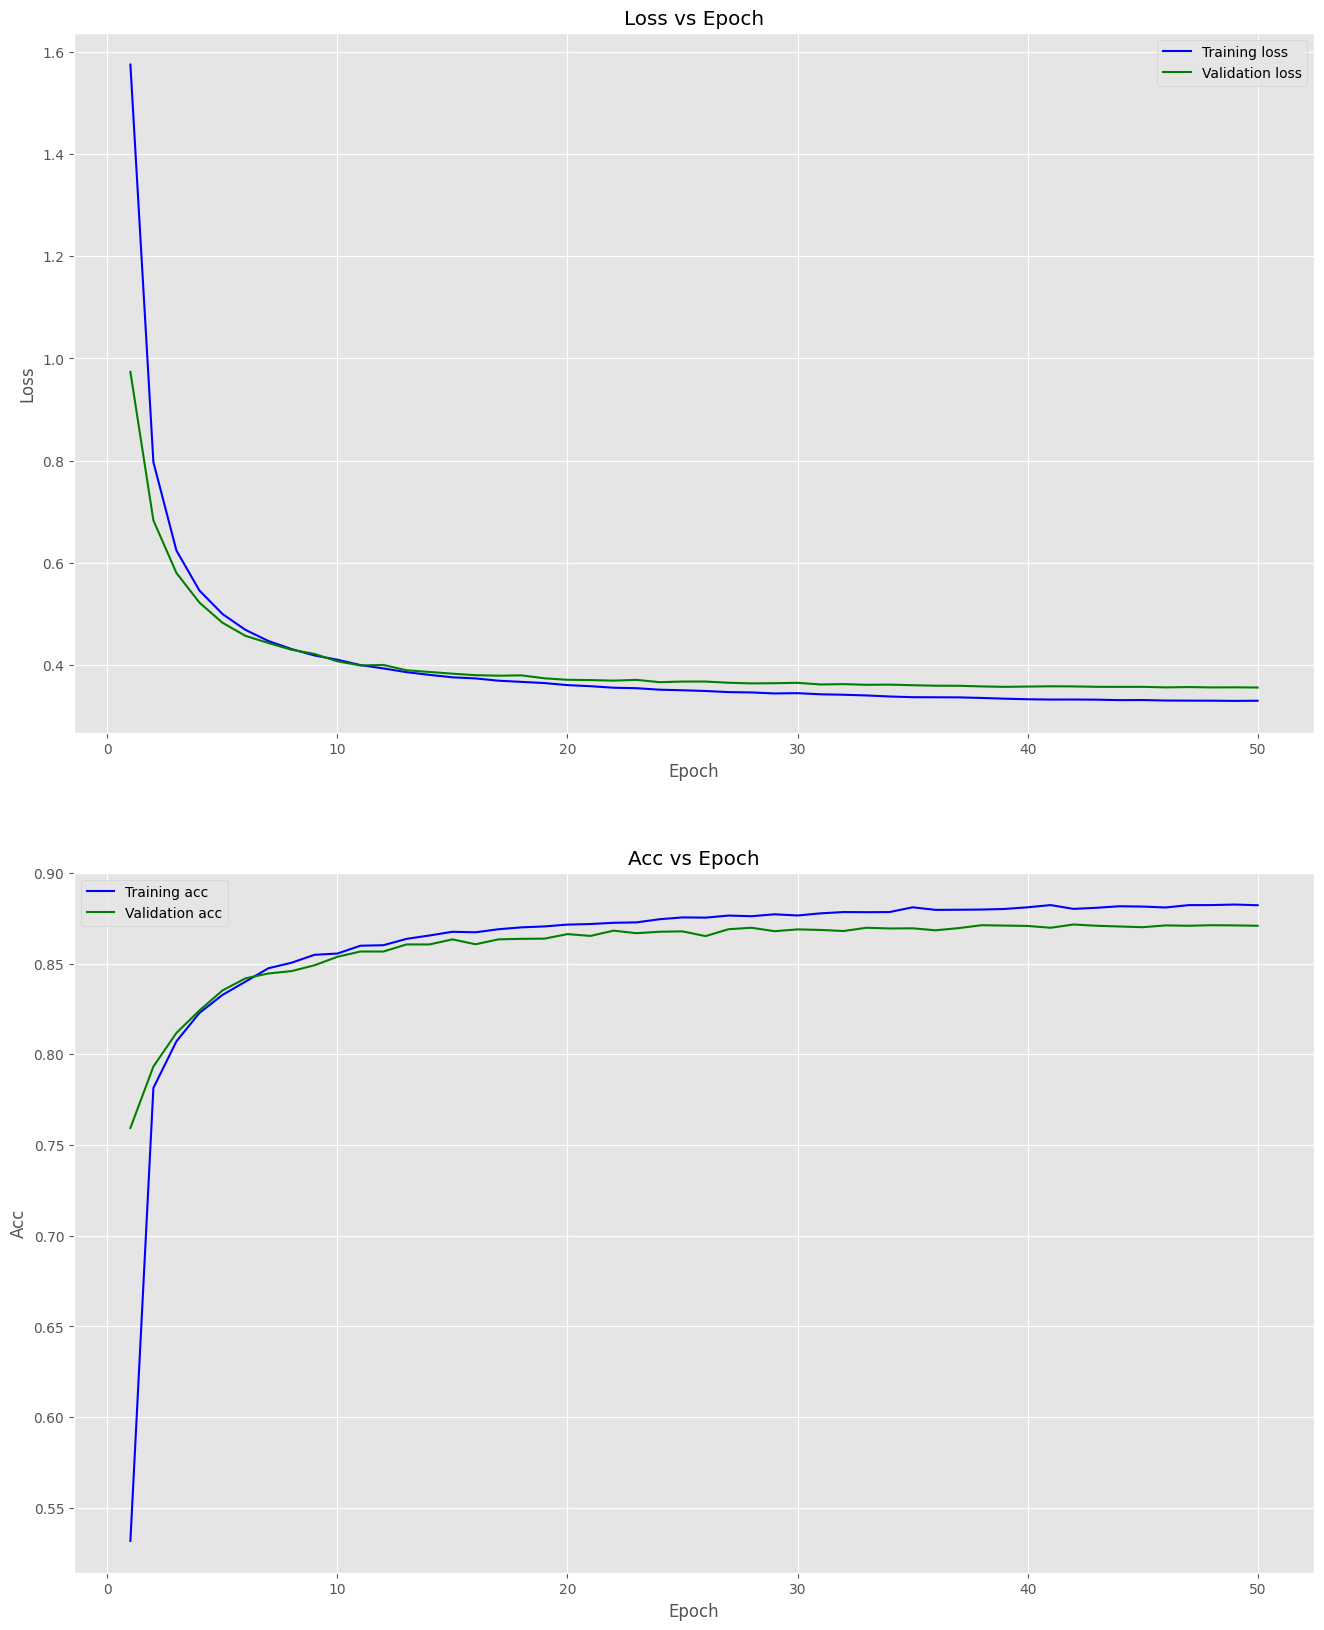

In [15]:

with plt.style.context("ggplot"):
    fig = plt.figure(figsize = (16, 20))

    ax0 = fig.add_subplot(2, 1, 1)
    ax0.plot(np.arange(1, num_epochs+1), history["train_loss"], label = "Training loss", c = "blue")
    ax0.plot(np.arange(1, num_epochs+1), history["val_loss"], label = "Validation loss", c = "green")
    ax0.set_title("Loss vs Epoch")
    ax0.set_xlabel("Epoch")
    ax0.set_ylabel("Loss")
    ax0.legend()
    ax0.grid(True)
    
    ax1 = fig.add_subplot(2, 1, 2)
    ax1.plot(np.arange(1, num_epochs+1), history["train_acc"], label = "Training acc", c = "blue")
    ax1.plot(np.arange(1, num_epochs+1), history["val_acc"], label = "Validation acc", c = "green")
    ax1.set_title("Acc vs Epoch")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Acc")
    ax1.legend()
    ax1.grid(True)

    plt.show()


In [16]:
# Save model
torch.save(model.state_dict(), "/mnt/d/Users/Admin/Projects/Machine_Learning/weights/fashionmnist_epoch_50_resnet18_onecycle.pth")

## Classification on Test data

In [17]:
new_model = models.resnet18(weights = None) # dont load ImageNet Weights
new_model.fc = nn.Linear(new_model.fc.in_features, len(labels_map))

# Load your trained weights
new_model.load_state_dict(torch.load(
    "/mnt/d/Users/Admin/Projects/Machine_Learning/weights/fashionmnist_epoch_50_resnet18_onecycle.pth",
    map_location=device
))

new_model = new_model.to(device)
new_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
test_data = datasets.FashionMNIST(
    root = data_pth,
    train = False,
    download = True,
    transform = data_transforms["test"]
)

test_loader = DataLoader(
    test_data,
    batch_size = 128,
    num_workers = 8,
    shuffle = False
)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = new_model(inputs)
        _, preds = torch.max(outputs, 1)

        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8692


In [20]:
for i in range(100):
    image, label = test_data[i]
    image_batch = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = new_model(image_batch)
        _, preds = torch.max(outputs, 1)

    pred_class = preds.item()
    
    # plt.imshow(image[0].squeeze(), cmap = "gray")
    # plt.title(f"image {i+1}")
    print(f"image {i+1} \n Pred: {labels_map[pred_class]}, True: {labels_map[label]}")
    plt.show()

image 1 
 Pred: Ankle Boot, True: Ankle Boot
image 2 
 Pred: Pullover, True: Pullover
image 3 
 Pred: Trouser, True: Trouser
image 4 
 Pred: Trouser, True: Trouser
image 5 
 Pred: Shirt, True: Shirt
image 6 
 Pred: Trouser, True: Trouser
image 7 
 Pred: Coat, True: Coat
image 8 
 Pred: Shirt, True: Shirt
image 9 
 Pred: Sandal, True: Sandal
image 10 
 Pred: Sneaker, True: Sneaker
image 11 
 Pred: Coat, True: Coat
image 12 
 Pred: Sandal, True: Sandal
image 13 
 Pred: Sneaker, True: Sneaker
image 14 
 Pred: Dress, True: Dress
image 15 
 Pred: Coat, True: Coat
image 16 
 Pred: Trouser, True: Trouser
image 17 
 Pred: Pullover, True: Pullover
image 18 
 Pred: T-Shirt, True: Coat
image 19 
 Pred: Bag, True: Bag
image 20 
 Pred: T-Shirt, True: T-Shirt
image 21 
 Pred: Pullover, True: Pullover
image 22 
 Pred: Sneaker, True: Sandal
image 23 
 Pred: Sneaker, True: Sneaker
image 24 
 Pred: Sandal, True: Ankle Boot
image 25 
 Pred: Trouser, True: Trouser
image 26 
 Pred: Shirt, True: Coat
image 

# Early Stoppage

In [9]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

patience = 5
best_val_loss = np.inf
epochs_without_improvement = 0
best_model_wts = None
delta = np.float32(0.01)

# Training loops
num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0 # correct predictions

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # clear the gradient from previous iteration

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels) # check if output and labels match

                if phase == "train":
                    loss.backward()
                    optimizer.step()
                    scheduler.step() # scheduler here if OneCycleLR

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
        history[f"{phase}_loss"].append(epoch_loss)
        history[f"{phase}_acc"].append(epoch_acc.item())

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if phase == "val":
            if best_val_loss - epoch_loss > delta:
                best_val_loss = epoch_loss
                epochs_without_improvement = 0
                best_model_wts = copy.deepcopy(model.state_dict())
            else:
                epochs_without_improvement += 1


    # scheduler.step()
    print(f"Epoch {epoch} LR: {scheduler.get_last_lr()[0]:.10f}")
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch}")
        model.load_state_dict(best_model_wts)
        break
    if epoch == 0:
        torch.save(copy.deepcopy(model.state_dict()), "/mnt/d/Users/Admin/Projects/Machine_Learning/weights/fashionmnist_resnet18_epoch1.pth")

print("Training complete!")

Epoch 0
train Loss: 1.6259 Acc: 0.5093
val Loss: 0.9969 Acc: 0.7559
Epoch 0 LR: 0.0006312923
Epoch 1
train Loss: 0.8004 Acc: 0.7836
val Loss: 0.6935 Acc: 0.7945
Epoch 1 LR: 0.0010194234
Epoch 2
train Loss: 0.6211 Acc: 0.8076
val Loss: 0.5866 Acc: 0.8141
Epoch 2 LR: 0.0016474069
Epoch 3
train Loss: 0.5414 Acc: 0.8240
val Loss: 0.5299 Acc: 0.8230
Epoch 3 LR: 0.0024877599
Epoch 4
train Loss: 0.4959 Acc: 0.8328
val Loss: 0.4965 Acc: 0.8280
Epoch 4 LR: 0.0035037049
Epoch 5
train Loss: 0.4665 Acc: 0.8390
val Loss: 0.4695 Acc: 0.8379
Epoch 5 LR: 0.0046507801
Epoch 6
train Loss: 0.4427 Acc: 0.8467
val Loss: 0.4527 Acc: 0.8434
Epoch 6 LR: 0.0058787848
Epoch 7
train Loss: 0.4266 Acc: 0.8516
val Loss: 0.4387 Acc: 0.8471
Epoch 7 LR: 0.0071339764
Epoch 8
train Loss: 0.4136 Acc: 0.8542
val Loss: 0.4294 Acc: 0.8491
Epoch 8 LR: 0.0083614226
Epoch 9
train Loss: 0.4036 Acc: 0.8582
val Loss: 0.4197 Acc: 0.8520
Epoch 9 LR: 0.0095074053
Epoch 10
train Loss: 0.3940 Acc: 0.8606
val Loss: 0.4133 Acc: 0.8539
E

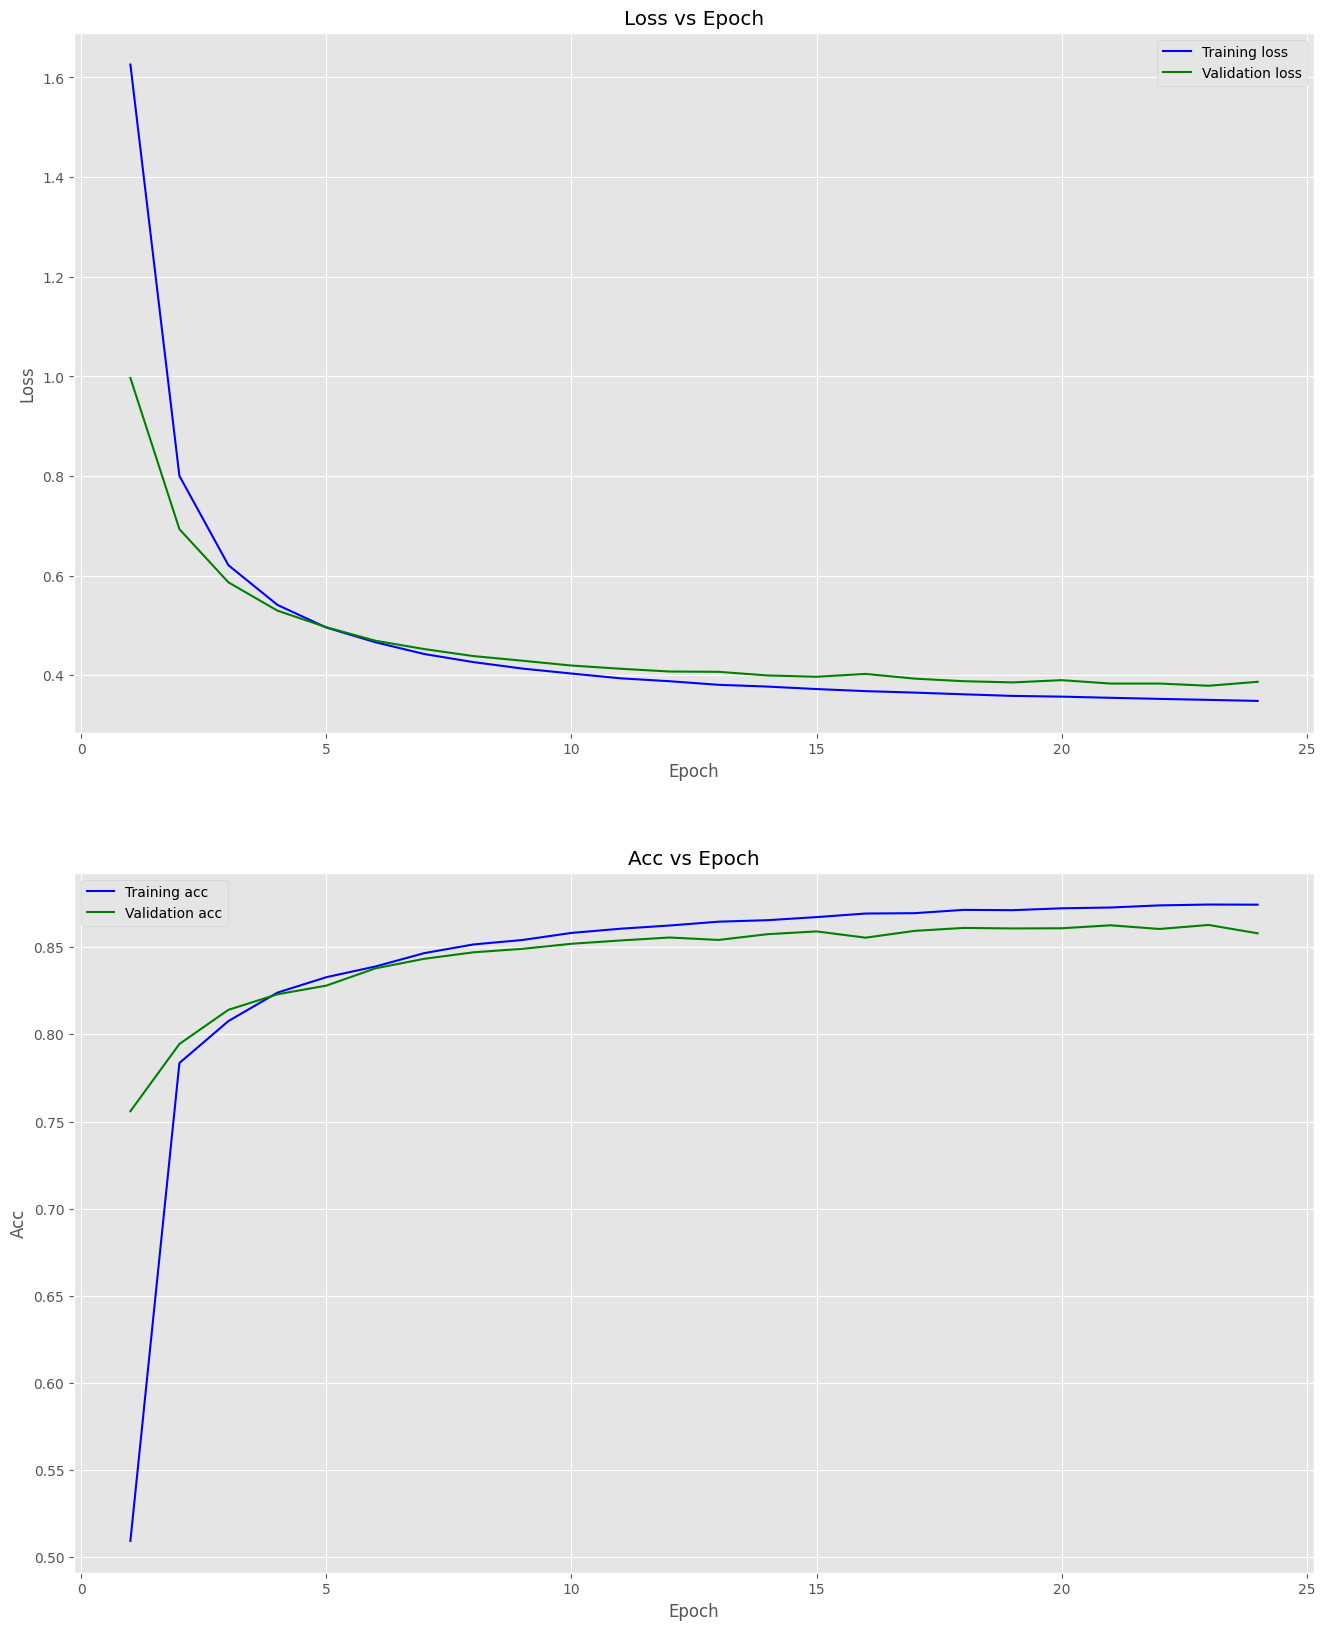

In [10]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize = (16, 20))

    ax0 = fig.add_subplot(2, 1, 1)
    ax0.plot(np.arange(1, len(history["train_loss"])+1), history["train_loss"], label = "Training loss", c = "blue")
    ax0.plot(np.arange(1, len(history["train_loss"])+1), history["val_loss"], label = "Validation loss", c = "green")
    ax0.set_title("Loss vs Epoch")
    ax0.set_xlabel("Epoch")
    ax0.set_ylabel("Loss")
    ax0.legend()
    ax0.grid(True)
    
    ax1 = fig.add_subplot(2, 1, 2)
    ax1.plot(np.arange(1, len(history["train_loss"])+1), history["train_acc"], label = "Training acc", c = "blue")
    ax1.plot(np.arange(1, len(history["train_loss"])+1), history["val_acc"], label = "Validation acc", c = "green")
    ax1.set_title("Acc vs Epoch")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Acc")
    ax1.legend()
    ax1.grid(True)

    plt.show()

In [11]:
# Save model
torch.save(best_model_wts, "/mnt/d/Users/Admin/Projects/Machine_Learning/weights/fashionmnist_resnet18_early_stpp_onecycle.pth")

In [12]:
new_model = models.resnet18(weights = None) # dont load ImageNet Weights
new_model.fc = nn.Linear(new_model.fc.in_features, len(labels_map))

# Load your trained weights
new_model.load_state_dict(torch.load(
    "/mnt/d/Users/Admin/Projects/Machine_Learning/weights/fashionmnist_resnet18_early_stpp_onecycle.pth",
    map_location=device
))

new_model = new_model.to(device)
new_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
test_data = datasets.FashionMNIST(
    root = data_pth,
    train = False,
    download = True,
    transform = data_transforms["test"]
)

test_loader = DataLoader(
    test_data,
    batch_size = 128,
    num_workers = 8,
    shuffle = False
)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = new_model(inputs)
        _, preds = torch.max(outputs, 1)

        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8649


# TSNE

In [15]:
feature_extractor = nn.Sequential(*list(new_model.children())[:-1])
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

features, labels_list = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        feats = feature_extractor(inputs)
        feats = feats.view(feats.size(0), -1)
        features.append(feats.cpu())
        labels_list.append(targets)

features = torch.cat(features).numpy()
labels_list = torch.cat(labels_list).numpy()

In [39]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    n_jobs=-1
)

features_2d = tsne.fit_transform(features)

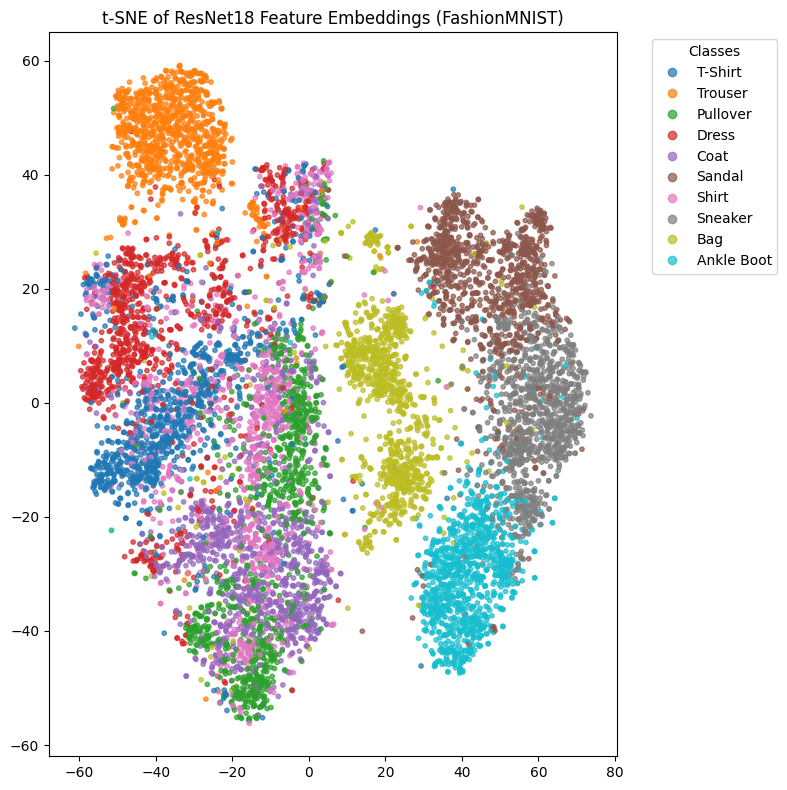

In [37]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    features_2d[:, 0],
    features_2d[:, 1],
    c=labels_list,
    cmap="tab10",
    s=10,
    alpha=0.7
)

plt.legend(
    handles=scatter.legend_elements()[0],
    labels=labels_map.values(),
    title="Classes",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.title("t-SNE of ResNet18 Feature Embeddings (FashionMNIST)")
plt.tight_layout()
plt.show()


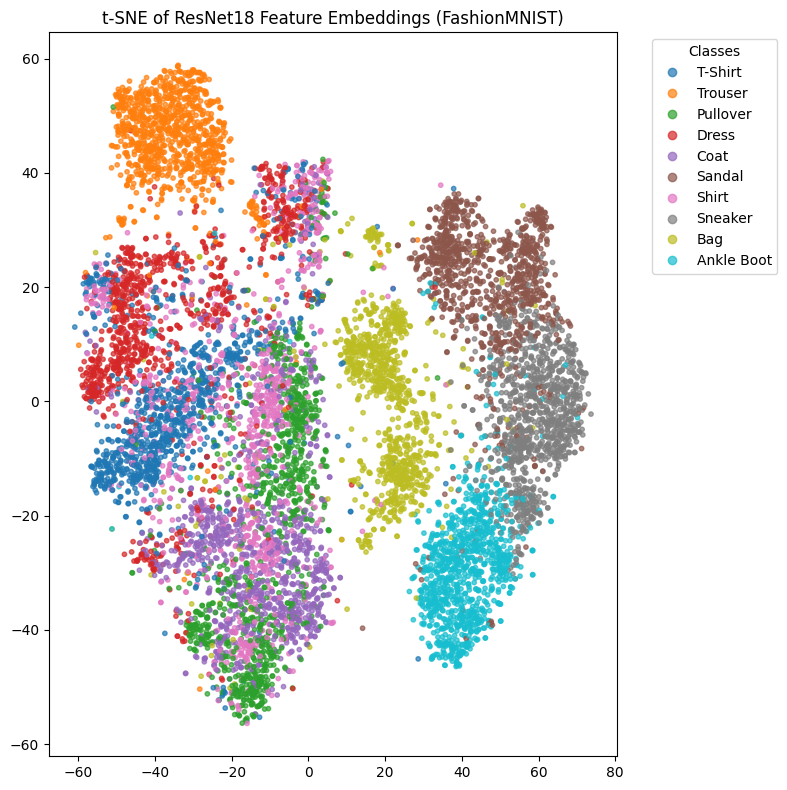

In [40]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    features_2d[:, 0],
    features_2d[:, 1],
    c=labels_list,
    cmap="tab10",
    s=10,
    alpha=0.7
)

plt.legend(
    handles=scatter.legend_elements()[0],
    labels=labels_map.values(),
    title="Classes",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.title("t-SNE of ResNet18 Feature Embeddings (FashionMNIST)")
plt.tight_layout()
plt.show()

# UMAP

In [16]:
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.25,
    n_components=2,
)

features_2d_umap = reducer.fit_transform(features)

/home/alvinng44/.local/share/mamba/envs/alyssa/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


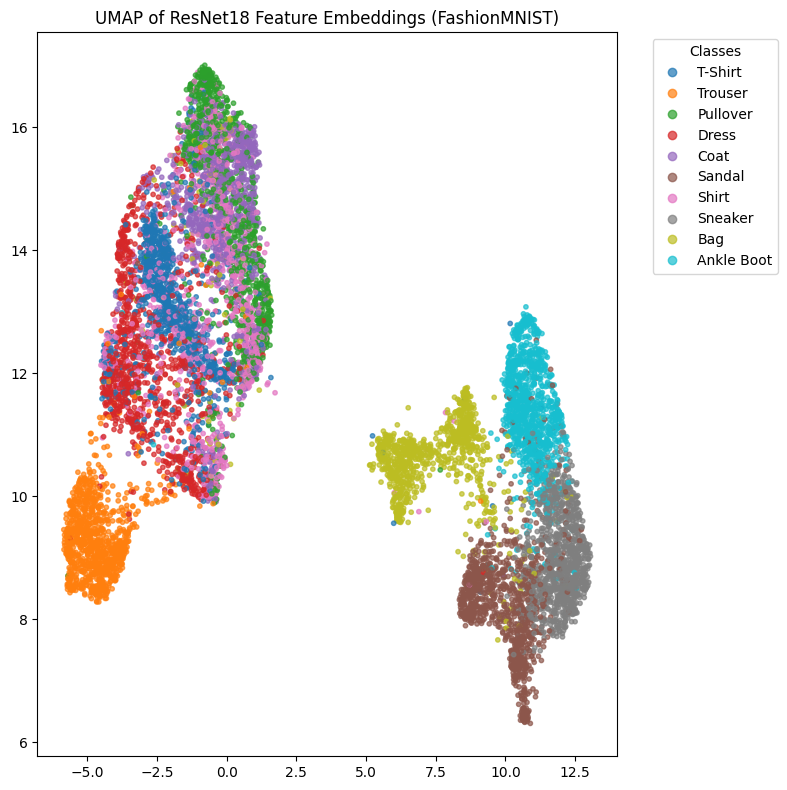

In [19]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    features_2d_umap[:, 0],
    features_2d_umap[:, 1],
    c=labels_list,
    cmap="tab10",
    s=10,
    alpha=0.7
)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=labels_map.values(),
    title="Classes",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.title("UMAP of ResNet18 Feature Embeddings (FashionMNIST)")
plt.tight_layout()
plt.show()

# epoch 0

In [12]:
model1 = models.resnet18(weights = None) # dont load ImageNet Weights
model1.fc = nn.Linear(model1.fc.in_features, len(labels_map))

# Load your trained weights
model1.load_state_dict(torch.load(
    "Machine_Learning_Studying/weights/fashionmnist_resnet18_epoch1.pth",
    map_location=device
))

model1 = model1.to(device)
model1.eval()

feature_extractor = nn.Sequential(*list(model1.children())[:-1])
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

features, labels_list = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        feats = feature_extractor(inputs)
        feats = feats.view(feats.size(0), -1)
        features.append(feats.cpu())
        labels_list.append(targets)

features = torch.cat(features).numpy()
labels_list = torch.cat(labels_list).numpy()

reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.25,
    n_components=2,
)

features_2d_umap = reducer.fit_transform(features)

/home/alvinng44/.local/share/mamba/envs/alyssa/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model1(inputs)
        _, preds = torch.max(outputs, 1)

        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.7617


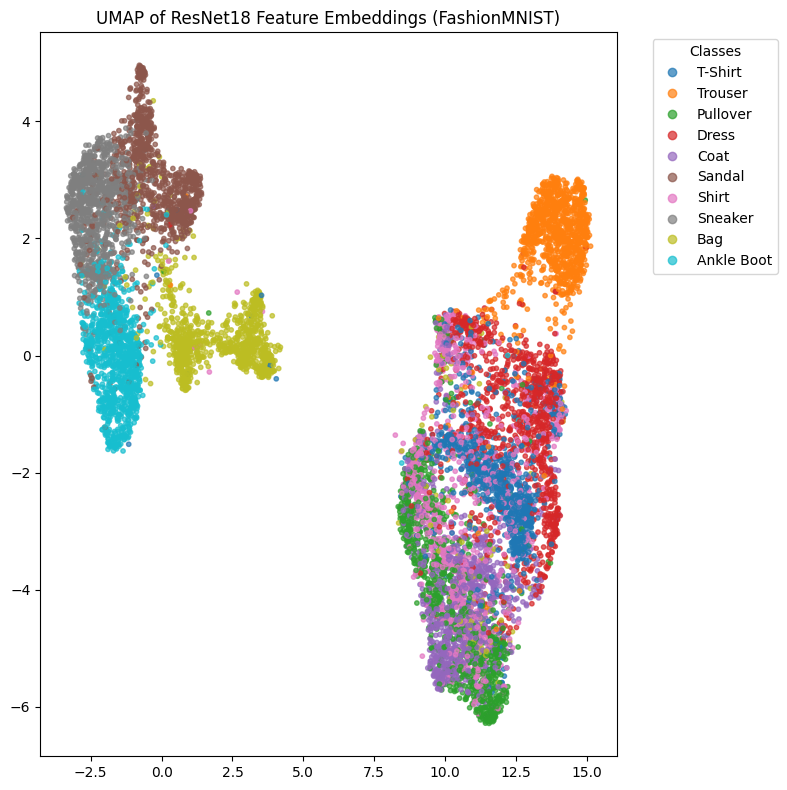

In [14]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    features_2d_umap[:, 0],
    features_2d_umap[:, 1],
    c=labels_list,
    cmap="tab10",
    s=10,
    alpha=0.7
)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=labels_map.values(),
    title="Classes",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.title("UMAP of ResNet18 Feature Embeddings (FashionMNIST)")
plt.tight_layout()
plt.show()

In [15]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    n_jobs=-1
)

features_2d = tsne.fit_transform(features)

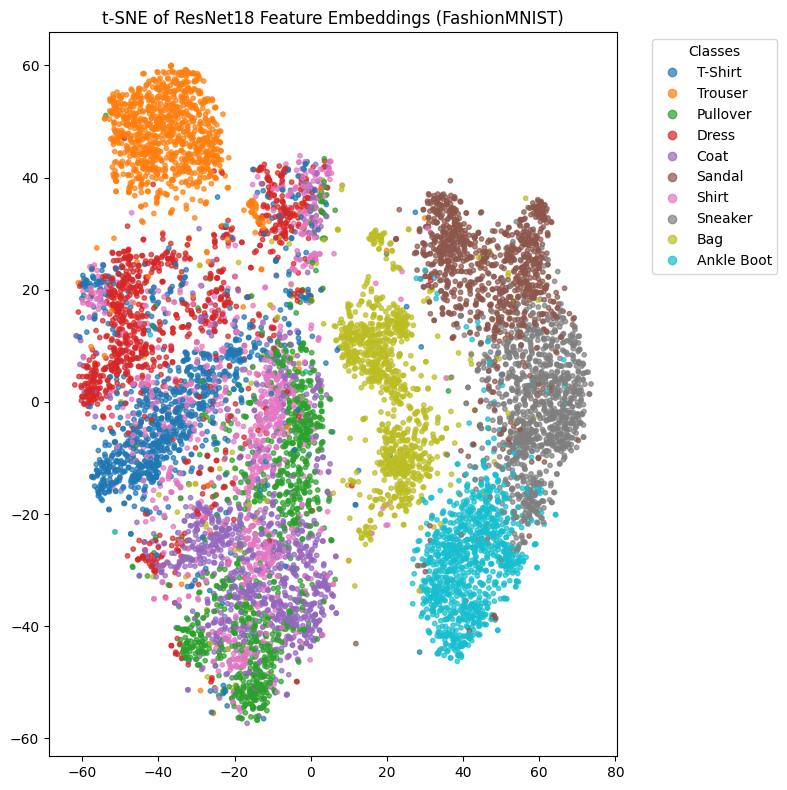

In [16]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    features_2d[:, 0],
    features_2d[:, 1],
    c=labels_list,
    cmap="tab10",
    s=10,
    alpha=0.7
)

plt.legend(
    handles=scatter.legend_elements()[0],
    labels=labels_map.values(),
    title="Classes",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.title("t-SNE of ResNet18 Feature Embeddings (FashionMNIST)")
plt.tight_layout()
plt.show()